# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM
import time

steps_learn = 10
steps_reg = 5
model_total = steps_learn * steps_reg

learning_rates_list = {}
regularization_strengths_list = {}
results = {}
best_val = -1
best_svm = None

for i in range(0, steps_learn):
    a = np.random.uniform(1e-4, 1e-1)
    learning_rates_list[i] = a

for j in range(0, steps_reg):
    b = np.random.uniform(1e-8, 1e-6)
    regularization_strengths_list[j] = b

a = np.arange(0,len(learning_rates_list))
b = np.arange(0,len(regularization_strengths_list))

svm = LinearSVM()
for i in a:
    for j in b:
        tic = time.time()
        svm.train(X_train_feats, y_train, learning_rates_list[i], regularization_strengths_list[j], num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(learning_rates_list[i],regularization_strengths_list[j])] = train_accuracy, val_accuracy
        toc = time.time()
        model = i*len(b)+j
        print('model: {0} / {1} computed in {2}s'.format(model, model_total, toc - tic))
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
            
            
            
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

model: 0 / 50 computed in 0.733664989471s
model: 1 / 50 computed in 1.02853083611s
model: 2 / 50 computed in 0.789277076721s
model: 3 / 50 computed in 0.611659049988s
model: 4 / 50 computed in 0.848509788513s
model: 5 / 50 computed in 0.611665010452s
model: 6 / 50 computed in 0.763412952423s
model: 7 / 50 computed in 0.702158927917s
model: 8 / 50 computed in 0.642867803574s
model: 9 / 50 computed in 0.679058074951s
model: 10 / 50 computed in 0.623856067657s
model: 11 / 50 computed in 0.673815011978s
model: 12 / 50 computed in 0.665864944458s
model: 13 / 50 computed in 0.613660097122s
model: 14 / 50 computed in 1.21405482292s
model: 15 / 50 computed in 0.930542945862s
model: 16 / 50 computed in 0.675422906876s
model: 17 / 50 computed in 0.741078138351s
model: 18 / 50 computed in 0.699555873871s
model: 19 / 50 computed in 1.22647118568s
model: 20 / 50 computed in 0.773648023605s
model: 21 / 50 computed in 0.899610042572s
model: 22 / 50 computed in 0.683760166168s
model: 23 / 50 computed 

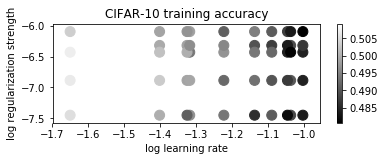

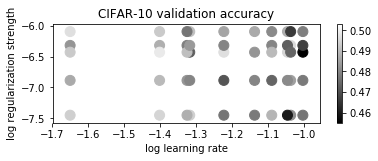

In [5]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.show()
# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()


In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.467


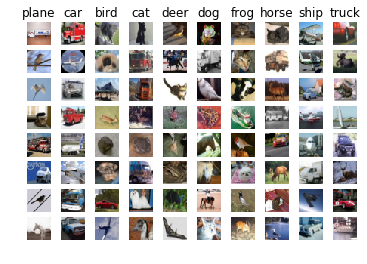

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [38]:
from cs231n.classifiers.neural_net import TwoLayerNet
import time
import itertools as it

best_net = None
results = {}
input_dim = X_train_feats.shape[1]
num_classes = 10

steps_lr = 10
steps_reg = 10
steps_hid = 3
model_total = steps_lr * steps_reg * steps_hid

learning_rates = {}
regularization_strengths = {}
hidden_layer = {}
best_val = 0
i = 0

learning_rates = [np.random.uniform(-2,4) for i in xrange(steps_lr)]
regularization_strengths = [10**np.random.uniform(-3, -7) for i in xrange(steps_reg)]
hidden_layer = [int(np.random.uniform(50,250)) for i in xrange(steps_hid)]

for lr, reg, hid in it.product(learning_rates, regularization_strengths,hidden_layer):
    i +=1
    tic = time.time()
    net = TwoLayerNet(input_dim, hid, num_classes)
    stats = net.train(X_train_feats, y_train,X_val_feats,y_val,
            num_iters=1000, batch_size=200,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, mu=0.5,verbose=False)
           
    y_train_pred = net.predict(X_train_feats)
    y_val_pred = net.predict(X_val_feats)
    train_accuracy = np.mean(y_train == y_train_pred)
    val_accuracy = np.mean(y_val == y_val_pred)
    results[(lr,reg,hid)] = train_accuracy, val_accuracy
    if val_accuracy > best_val:
            best_val = val_accuracy
            best_net = net
    toc = time.time()
    model = k*len(a)*len(b)+i*len(b)+j+1
    print('model: {0} / {1} computed in {2}s'.format(i, model_total, toc - tic))


for lr, reg, hid in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hid)]
    print('lr {0} reg {1} hid {2} train accuracy: {3} val accuracy: {4}'.format(
                lr, reg, hid, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: {}'.format(best_val))               
#####################################################

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

model: 3 / 300 computed in 4.91849112511s
model: 4 / 300 computed in 2.0093100071s
model: 5 / 300 computed in 2.78998112679s
model: 6 / 300 computed in 4.28831887245s
model: 7 / 300 computed in 1.98965001106s
model: 8 / 300 computed in 2.81043386459s
model: 9 / 300 computed in 4.3366420269s
model: 10 / 300 computed in 2.0025780201s
model: 11 / 300 computed in 2.77604389191s
model: 12 / 300 computed in 4.31126594543s
model: 13 / 300 computed in 1.93215918541s
model: 14 / 300 computed in 2.84929800034s
model: 15 / 300 computed in 4.31529211998s
model: 16 / 300 computed in 1.94875717163s
model: 17 / 300 computed in 2.74960899353s
model: 18 / 300 computed in 4.38642406464s
model: 19 / 300 computed in 1.94857215881s
model: 20 / 300 computed in 2.77799606323s
model: 21 / 300 computed in 4.46153593063s
model: 22 / 300 computed in 1.94689798355s
model: 23 / 300 computed in 2.74662899971s
model: 24 / 300 computed in 4.38627409935s
model: 25 / 300 computed in 1.95117592812s
model: 26 / 300 compu

cs231n/classifiers/neural_net.py:108: RuntimeWarning: divide by zero encountered in log
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #normalize for each example
cs231n/classifiers/neural_net.py:105: RuntimeWarning: overflow encountered in subtract
  
cs231n/classifiers/neural_net.py:105: RuntimeWarning: invalid value encountered in subtract
  
cs231n/classifiers/neural_net.py:80: RuntimeWarning: invalid value encountered in maximum
  p = 1
cs231n/classifiers/neural_net.py:137: RuntimeWarning: invalid value encountered in less_equal
  # backprop the ReLU non-linearity
cs231n/classifiers/neural_net.py:280: RuntimeWarning: invalid value encountered in maximum
  


model: 33 / 300 computed in 4.4206469059s
model: 34 / 300 computed in 1.96220207214s
model: 35 / 300 computed in 2.79353284836s
model: 36 / 300 computed in 4.37990188599s
model: 37 / 300 computed in 1.96270704269s
model: 38 / 300 computed in 2.79445004463s
model: 39 / 300 computed in 4.37847018242s
model: 40 / 300 computed in 1.9577460289s
model: 41 / 300 computed in 2.94978094101s
model: 42 / 300 computed in 4.50083994865s
model: 43 / 300 computed in 1.95384407043s
model: 44 / 300 computed in 2.75700092316s
model: 45 / 300 computed in 4.38142108917s
model: 46 / 300 computed in 1.96304488182s
model: 47 / 300 computed in 2.80086803436s
model: 48 / 300 computed in 4.46538901329s
model: 49 / 300 computed in 1.95912313461s
model: 50 / 300 computed in 2.7637860775s
model: 51 / 300 computed in 4.43576407433s
model: 52 / 300 computed in 1.9527361393s
model: 53 / 300 computed in 2.75865101814s
model: 54 / 300 computed in 4.38450789452s
model: 55 / 300 computed in 1.94825100899s
model: 56 / 300

model: 222 / 300 computed in 4.38687682152s
model: 223 / 300 computed in 1.9611158371s
model: 224 / 300 computed in 3.01297998428s
model: 225 / 300 computed in 4.58320403099s
model: 226 / 300 computed in 1.96077394485s
model: 227 / 300 computed in 2.98341798782s
model: 228 / 300 computed in 4.48722887039s
model: 229 / 300 computed in 1.95735096931s
model: 230 / 300 computed in 2.77106595039s
model: 231 / 300 computed in 4.39118313789s
model: 232 / 300 computed in 1.97418212891s
model: 233 / 300 computed in 2.79547691345s
model: 234 / 300 computed in 4.49656796455s
model: 235 / 300 computed in 2.07154488564s
model: 236 / 300 computed in 2.79171586037s
model: 237 / 300 computed in 4.40461611748s
model: 238 / 300 computed in 2.14090895653s
model: 239 / 300 computed in 2.84281992912s
model: 240 / 300 computed in 4.38234210014s
model: 241 / 300 computed in 1.95336508751s
model: 242 / 300 computed in 2.78599309921s
model: 243 / 300 computed in 4.33725690842s
model: 244 / 300 computed in 1.89

In [39]:
print(results)

{(-0.9598442626723167, 6.093196298039742e-06, 233): (0.10026530612244898, 0.087), (1.4188401169682159, 5.871340169547498e-06, 233): (0.6500816326530612, 0.547), (1.4188401169682159, 1.8495517848748026e-05, 140): (0.6285918367346939, 0.538), (1.4188401169682159, 2.8157869778574975e-06, 140): (0.6262857142857143, 0.539), (-0.18957489736244826, 1.994651597988652e-07, 233): (0.10044897959183674, 0.078), (-0.9598442626723167, 4.986332314052734e-06, 233): (0.10026530612244898, 0.087), (1.8461078224983014, 1.6485490507533268e-05, 88): (0.5860612244897959, 0.522), (-1.458489766109398, 3.3335987119000153e-07, 88): (0.10026530612244898, 0.087), (-0.9598442626723167, 1.6485490507533268e-05, 140): (0.10026530612244898, 0.087), (-1.246439517493767, 6.093196298039742e-06, 88): (0.10026530612244898, 0.087), (1.4188401169682159, 2.8157869778574975e-06, 233): (0.6495102040816326, 0.542), (2.1081183034065054, 6.093196298039742e-06, 233): (0.6206326530612245, 0.519), (-0.18957489736244826, 8.361916845194

In [40]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.show()
# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

ValueError: math domain error

In [41]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.562
